# Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План работы

### Подготовка

1. Загрузка данных
2. Изучение данных на предмет целостности, корректности, а также распределения
3. Определение значимых параметров
4. Сведение всех значимых параметров в единый датафрейм
5. Деление на тренировочную, валидационную и тестовую выборки

### Определение наилучшей модели

1. Линейная регрессия
2. Decision Tree
3. Random Forest
4. CatBoost
5. LightGBM

### Подбор оптимальных параметров

Для 2-3 лучших моделей подбираем гиперпараметры 

### Описание проделанной работы и выводы

1. Пересказ последовательности действий с объяснением 
2. Общий вывод и готовая модель


In [1]:
# Импорт необходимых библиотек и компонентов
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install catboost
from catboost import CatBoostRegressor

In [3]:
!pip install lightgbm
import lightgbm as lgb

## Подготовка данных

In [4]:
# Импорт данных
path = ''
# path = '/datasets/final_steel/'
arc = pd.read_csv(path + 'data_arc.csv')
bulk_v = pd.read_csv(path + 'data_bulk.csv')
bulk_t = pd.read_csv(path + 'data_bulk_time.csv')
gas = pd.read_csv(path + 'data_gas.csv')
tem = pd.read_csv(path + 'data_temp.csv')
wire_v = pd.read_csv(path + 'data_wire.csv')
wire_t = pd.read_csv(path + 'data_wire_time.csv')

Будес собирать фичи в одну таблицу. Основные приципы:

1. Все признаки будем сводить внутри одной партии
2. В качествек целевого признака берем последнее измерение температуры
3. Моментные временные метки игнорируем, используем только временные промежутки

### Данные об электродах


In [5]:
arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


Имеются временные промежуткми и мощности на этих промежутках. Для датафрейма делаем преобразования: 
1. Группируем строки по партиям 
2. Для каждой партии вычисляем суммарное время нагрева  и затраченные мощности

In [6]:
#Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов
temp_1 = arc.copy()
temp_1 = temp_1.rename(columns={'Начало нагрева дугой': 'begin', 'Конец нагрева дугой': 'end',
                          'Активная мощность': 'active_p', 'Реактивная мощность': 'reactive_p'})
temp_1['begin'] = pd.to_datetime(temp_1['begin'], format='%Y-%m-%d %H:%M:%S')
temp_1['end'] = pd.to_datetime(temp_1['end'], format='%Y-%m-%d %H:%M:%S') 
temp_1['time'] = temp_1['end'] - temp_1['begin']
temp_1['time'] = temp_1['time'].dt.total_seconds()
temp_1 = temp_1.groupby('key').agg(sum)

In [7]:
temp_1

,active_p,reactive_p,time
key,,,
1,4.878147,3.183241,1098.0
2,3.052598,1.998112,811.0
3,2.525882,1.599076,655.0
4,3.209250,2.060298,741.0
5,3.347173,2.252643,869.0
...,...,...,...
3237,3.932467,2.828459,909.0
3238,2.106529,1.681182,546.0
3239,4.666754,3.111617,1216.0


In [8]:
temp_1.describe() 

,active_p,reactive_p,time
count,3214.000000,3214.000000,3214.000000
mean,3.103138,2.094821,794.579029
std,1.397390,12.689508,332.448622
min,0.186226,-714.591636,57.000000
25%,2.126339,1.599018,571.000000
50%,2.990537,2.229869,770.000000
75%,3.901147,2.899141,983.000000
max,17.496497,12.587990,4189.000000


По статистике датафрейма можно увидеть что:
1. Есть отрицательные значения мощности. Эти партии надо будет исключить из общей таблицы
2. Распределение относительно нормальное. На что указывает примерное равенство медианы и среднего

In [9]:
# Удали строки с отрицательным значением мощности
temp_1 = temp_1[temp_1['reactive_p'] > 0]

In [10]:
temp_1.isna().sum()

active_p      0
reactive_p    0
time          0
dtype: int64

### Данные о подаче сыпучих материалов

In [11]:
bulk_v

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Строк меньше чем в предыдущей таблице. Проверим уникальность ключа 'key'

In [12]:
len(bulk_v['key'].unique( ))

3129

Все значения уникальны. Это говорит о том, что подача сыпучих материалов производилась не во все партии.  
Заменим NaN на 0, т.к. отсутствие подачи означает, что было добавлено 0 материала

In [13]:
temp_2 = bulk_v.fillna(0)

In [14]:
temp_2.describe() 

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


### Данные о продувке сплава газом

In [15]:
gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [16]:
gas.describe() 

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Распределение относительно нормальное. На что указывает примерное равенство медианы и среднего

In [17]:
# Переименование столбца
gas = gas.rename(columns={'Газ 1': 'gas'})

In [18]:
temp_3 = gas.copy()

Добавляем полностью как фичу

### Результаты измерения температуры

In [24]:
tem

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [53]:
# Приведение названий столбцов к общепринятому формату
temp_4 = tem.rename(columns={'Время замера': 'time', 'Температура': 'temp'})

Как целевое значение берем последнее измерение температуры в партии. Если оно единственное, считаем что партия неудачна и ее удаляем. Удаляем все NaN. Удаляем неужный столбец со временем

In [54]:
# Группируем по партии и смотрим последнее значение в столбце температуры и количество измерений
temp_4 = temp_4.groupby('key').agg({'temp': ['first', 'last', 'count']})
# Преобразуем двойные названия столбцов
temp_4.columns = temp_4.columns.droplevel()

In [55]:
temp_4

,first,last,count
key,,,
1,1571.0,1613.0,5
2,1581.0,1602.0,6
3,1596.0,1599.0,5
4,1601.0,1625.0,3
5,1576.0,1602.0,2
...,...,...,...
3237,1569.0,1569.0,1
3238,1584.0,1584.0,1
3239,1598.0,1598.0,1


In [56]:
# Удаляем партии с единственным измерением
temp_4 = temp_4.loc[temp_4['count'] != 1]

In [57]:
# Переименовываем столбец температуры и удаляем ненужный столбец с количеством измерений
temp_4 = temp_4.rename(columns={'last': 'temp', 'first': 'temp_f'})
temp_4 = temp_4.drop('count', 1)

In [58]:
temp_4

,temp_f,temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


### Данные о проволочных материалах

Поступаем с таблицей аналогично bulk_v

In [59]:
wire_v

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
temp_5 = wire_v.fillna(0)

In [61]:
temp_5

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
temp_5.describe() 

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Типы проволок с 2 по 9 используются крайне редко, но все равно включим их в модель

## Формирование основного датафрейма с данными

Учитывая, что основная таблица - таблица с целевым признаком, монтируем к ней остальные

In [63]:
df = pd.merge(temp_4, temp_1, on='key', how='left')
df = pd.merge(df, temp_2, on='key', how='left')
df = pd.merge(df, temp_3, on='key', how='left')
df = pd.merge(df, temp_5, on='key', how='left')

In [64]:
# Приведение названий столбцов к общепринятому формату
df.columns = df.columns.str.replace(' ', '_')
df.columns = [x.lower() for x in df.columns]
# Удаление NaN
df = df.dropna()

In [65]:
df

,key,temp_f,temp,active_p,reactive_p,time,bulk_1,bulk_2,bulk_3,bulk_4,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,4.878147,3.183241,1098.0,0.0,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,3.052598,1.998112,811.0,0.0,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,2.525882,1.599076,655.0,0.0,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,3.209250,2.060298,741.0,0.0,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,3.347173,2.252643,869.0,0.0,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3.210690,2.360777,723.0,0.0,0.0,21.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,2496,1554.0,1591.0,4.203064,2.810185,940.0,0.0,0.0,0.0,63.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,2497,1571.0,1589.0,2.212379,1.851269,569.0,0.0,0.0,0.0,85.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,2498,1591.0,1594.0,3.408725,2.355428,750.0,0.0,0.0,90.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Проверим зависимости между признаками

,active_p,gas,reactive_p,time
active_p,1.000000,0.368223,0.965773,0.984179
gas,0.368223,1.000000,0.432854,0.401327
reactive_p,0.965773,0.432854,1.000000,0.979387
time,0.984179,0.401327,0.979387,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017A287B9A30>,
      dtype=object)

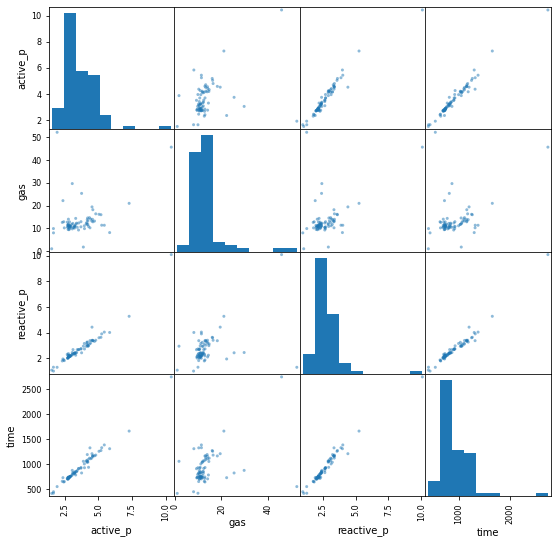

In [66]:
# Содздание матрицы зависимостей
multi_stat = df.pivot_table(index='temp', values=['active_p','reactive_p', 'time', 'gas'])
display(multi_stat.corr())
pd.plotting.scatter_matrix(multi_stat, figsize=(9, 9))

Да, зависимость очень сильная между мощностями и временем и активной мощностью. Но со временем понятно - чем больше по времени нагреваешь, тем большая мощность нужна. Есть предложение соединить мощности в один признак - Полная мощность, которая вычисляется как корень кавдратный из суммы квадратов мощностей.

In [67]:
df

,key,temp_f,temp,active_p,reactive_p,time,bulk_1,bulk_2,bulk_3,bulk_4,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,4.878147,3.183241,1098.0,0.0,0.0,0.0,43.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,3.052598,1.998112,811.0,0.0,0.0,0.0,73.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,2.525882,1.599076,655.0,0.0,0.0,0.0,34.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,3.209250,2.060298,741.0,0.0,0.0,0.0,81.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,3.347173,2.252643,869.0,0.0,0.0,0.0,78.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2495,1570.0,1591.0,3.210690,2.360777,723.0,0.0,0.0,21.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,2496,1554.0,1591.0,4.203064,2.810185,940.0,0.0,0.0,0.0,63.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,2497,1571.0,1589.0,2.212379,1.851269,569.0,0.0,0.0,0.0,85.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,2498,1591.0,1594.0,3.408725,2.355428,750.0,0.0,0.0,90.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# df['power'] = (df['active_p']**2 + df['reactive_p']**2)**0.5

In [69]:
df = df.drop(['active_p', 'key'], 1)

In [70]:
df

,temp_f,temp,reactive_p,time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1571.0,1613.0,3.183241,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,1.998112,811.0,0.0,0.0,0.0,73.0,0.0,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,1.599076,655.0,0.0,0.0,0.0,34.0,0.0,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,2.060298,741.0,0.0,0.0,0.0,81.0,0.0,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,2.252643,869.0,0.0,0.0,0.0,78.0,0.0,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,1570.0,1591.0,2.360777,723.0,0.0,0.0,21.0,0.0,0.0,0.0,...,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2471,1554.0,1591.0,2.810185,940.0,0.0,0.0,0.0,63.0,0.0,0.0,...,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2472,1571.0,1589.0,1.851269,569.0,0.0,0.0,0.0,85.0,0.0,0.0,...,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2473,1591.0,1594.0,2.355428,750.0,0.0,0.0,90.0,0.0,0.0,0.0,...,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Определение оптимальной модели

In [71]:
# Разбиение на тестовую и валидационную выборки
train, test = train_test_split(df, test_size=0.3, random_state=42)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
X_train = train.drop(['temp'], axis=1)
y_train = train['temp']
X_test = test.drop(['temp'], axis=1)
y_test = test['temp']

In [72]:
# Функция вывода значимости признаков
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('Знаимость признаков в модели ' + model_type)
    plt.xlabel('Значимость')
    plt.ylabel('Признаки')

### Линейная регрессия

In [73]:
# Обучение и оценка модели
lr = LinearRegression()
lr.fit(X_train, y_train) 
pred = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, pred)
importances = lr.coef_
print("MAE:", mae_lr)

MAE: 6.486401797281631


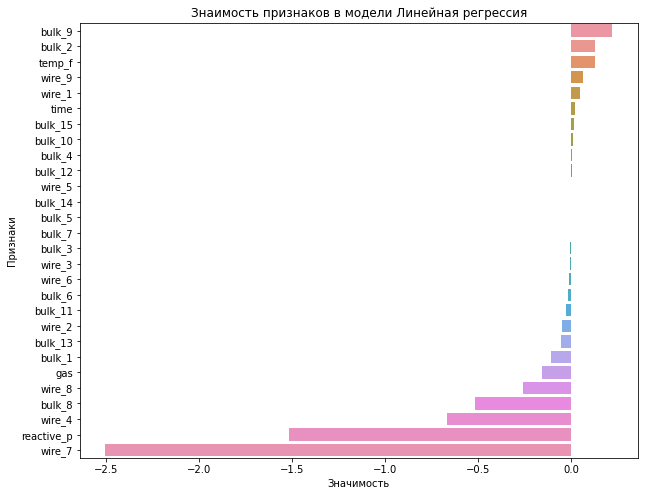

In [74]:
# Вывод степени значимости признаков 
plot_feature_importance(importances,X_train.columns,'Линейная регрессия')

### Дерево решений

In [75]:
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeRegressor(random_state=42, max_depth=depth)
    model.fit(X_train, y_train) 
    pred = model.predict(X_test)
    result = mean_absolute_error(y_test, pred)
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
mae_dtr = result
importances = best_model.feature_importances_
print("MAE:", mae_dtr, "Количество деревьев:", best_depth)

MAE: 7.172614376650785 Количество деревьев: 5


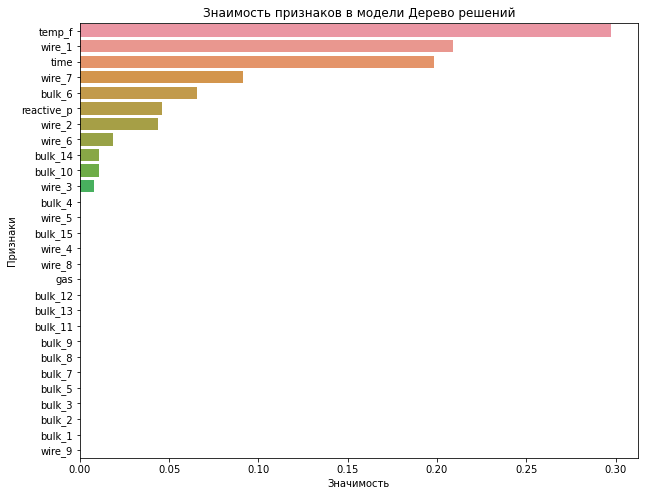

In [76]:
# Вывод степени значимости признаков 
plot_feature_importance(importances,X_train.columns,'Дерево решений')

### Случайный лес

In [77]:
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=42, n_estimators=est, max_depth=depth)
        model.fit(X_train, y_train) 
        pred = model.predict(X_test)
        result = mean_absolute_error(y_test, pred)
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
mae_rfr = best_result
importances = best_model.feature_importances_
print("MAE:", mae_rfr, "Количество деревьев:", best_est, "Максимальная глубина:", depth)

MAE: 6.119390453648762 Количество деревьев: 10 Максимальная глубина: 10


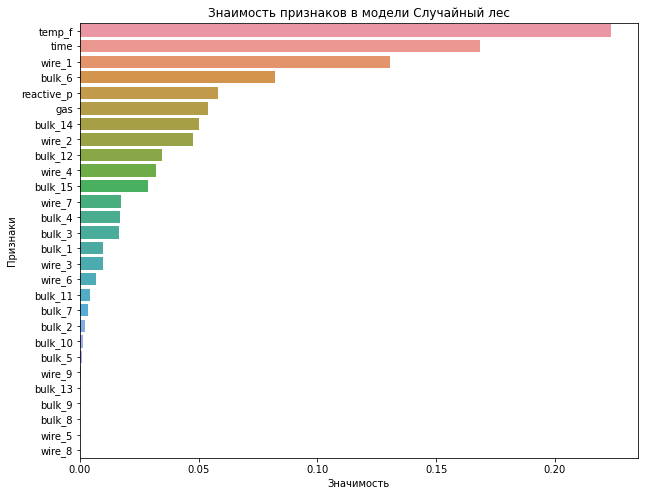

In [78]:
# Вывод степени значимости признаков 
plot_feature_importance(importances,X_train.columns,'Случайный лес')

### CatBoost

In [79]:
# Подбор параметров модели
model = CatBoostRegressor(eval_metric='MAE', silent=True)
parameters = {'depth'         : [6,8,10],
             'learning_rate' : [0.01, 0.05, 0.1],
             'iterations'    : [30, 50, 100]
              }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3)
grid.fit(X_train, y_train)

print("\n Наилучший результат:\n", grid.best_score_)
print("\n Наилучшие параметры:\n", grid.best_params_)


 Наилучший результат:
 0.3943388755697093

 Наилучшие параметры:
 {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}


In [80]:
# Обучение и оценка модели
cbr = CatBoostRegressor(eval_metric='R2', depth = 10, iterations = 100, learning_rate = 0.1, silent=True)
cbr.fit(X_train, y_train) 
pred = cbr.predict(X_test)
mae_cbr = mean_absolute_error(y_test, pred)
print("MAE:", mae_cbr)

MAE: 6.166850337313393


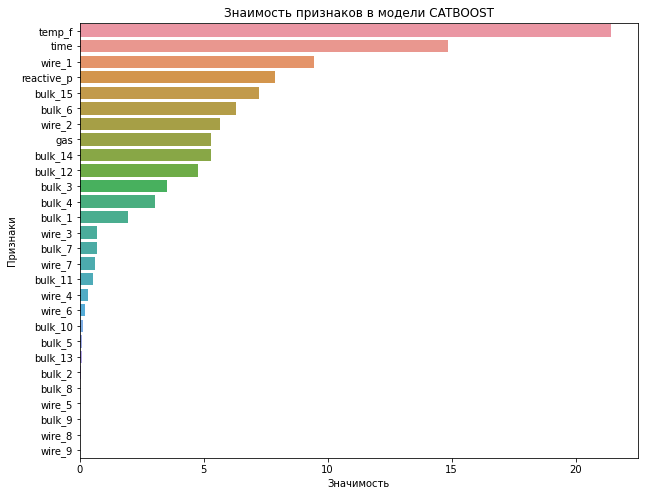

In [81]:
# Вывод степени значимости признаков 
plot_feature_importance(cbr.get_feature_importance(),X_train.columns,'CATBOOST')

### LightGBM

In [82]:
# Подор параметров
model = lgb.LGBMRegressor(metric='mae', silent=True)

parameters = {'num_leaves': [31, 127, 257],
              'min_data_in_leaf': [20, 30, 50, 100, 300],
              'learning_rate': [.03, .05, .07],
              'max_depth': [5, 6, 7],
             }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3)
grid.fit(X_train, y_train)

print("\n Наилучший результат:\n", grid.best_score_)
print("\n Наилучшие параметры:\n", grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [83]:
# Обучение и оценка модели
lgbm = lgb.LGBMRegressor(metric='mae', min_data_in_leaf = 50, num_leaves = 31, max_depth = 5, learning_rate = 0.05)
lgbm.fit(X_train, y_train) 
pred = lgbm.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, pred)
print("MAE:", mae_lgbm)

MAE: 6.0769034692730015


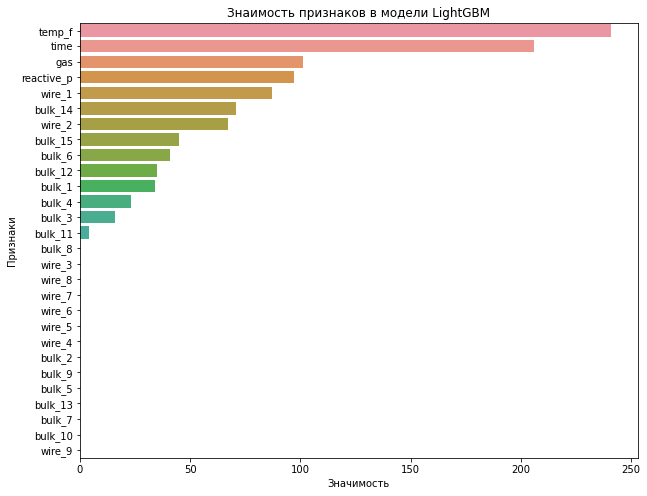

In [84]:
# Вывод степени значимости признаков 
plot_feature_importance(lgbm.feature_importances_,X_train.columns,'LightGBM')

## Сравнение результатов моделей

In [85]:
# Сравнителшьная таблица
d = {'MAE':np.array([mae_lr, mae_dtr, mae_rfr, mae_cbr, mae_lgbm])}
result = pd.DataFrame(d, index=['Линейная регрессия', 'Дерево решений', 'Случайный лес', 'Cat Boost', 'LightGBM'])
result.sort_values('MAE')

,MAE
LightGBM,6.076903
Случайный лес,6.119390
Cat Boost,6.166850
Линейная регрессия,6.486402
Дерево решений,7.172614


# Выводы 
Наиболее оптимальной моделью является модель построенная с помощью LightGBM  
Основномы фичами влияющими на результат являются _"Температура до процесса", "Время нагрева", "Подача газа"_.

# Отчет

## Какие пункты плана были выполнены, а какие — нет.

1. В первой части "Подготовка" были выполнены почти все пункты кроме разбиения на 3 выборки. Ограничился двумя. Данных для работы осталось не много. 
2. Все модели были построены
3. Подбор оптимальных параметров делался одновременно во всех моделях.
4. Были сделаны выводы по оптимальной модели и параметрам наиблее влияющим на предсказание температуры

## Какие трудности возникли и как вы их преодолели

1. Не сразу достиг задонной точности. Пришлось изменять входящие признаки. Как не странно, но основной вклад в улучшение внесла начальная температура.
2. Забыл про анализ признаков с помощью _feature_importances_ . После замечания исправил и псотроил графики.
3. Дальнейшее изменение входящих признаков улучшения не дало. Например вместо веремени и 2 мощностей пытался сделать один признак - "Энергия"

## Какие ключевые шаги в решении задачи

1. Анализ входящих данных и аккумуляция важных входящих признаков в одну таблицу. Одновременно избавление от пропусков и выбросов. Последовательно по всем исходным таблицам
2. Выбор моделей подходящих для каждого случая и их построение
3. Оформление в виде наглядных графиков и таблиц
4. Анализ результатов

## Какая итоговая модель и какое у неё качество

Оптимальной моделью получилась градиентный бустинг LightGBM с метрикой МАЕ = 6.07